In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, mean_squared_error, classification_report
from sklearn import  model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from vecstack import stacking, StackingTransformer
from xgboost import XGBClassifier
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from sklearn.linear_model import LogisticRegression

<br>

## 1. Preparing dataset (2번부터 실습 진행)

In [83]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

titan_df = data_df.drop(columns=['PassengerId'])
titan_df.describe()
titan_df[titan_df.Age == np.min(titan_df.Age)]
# titan_df[titan_df.Age == np.max(titan_df.Age)]

titan_df[titan_df.Age == np.min(titan_df.Age)]
titan_df.iloc[:, [2, 4]]

,Name,Age
0,"Braund, Mr. Owen Harris",22.0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0
2,"Heikkinen, Miss. Laina",26.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0
4,"Allen, Mr. William Henry",35.0
...,...,...
886,"Montvila, Rev. Juozas",27.0
887,"Graham, Miss. Margaret Edith",19.0
888,"Johnston, Miss. Catherine Helen ""Carrie""",NaN
889,"Behr, Mr. Karl Howell",26.0


## Data info

- **PassengerId** : Unique ID of passenger 승객번호
- **Survived** : 0 = No, 1 = Yes 생존여부
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd) 객실 클래스
- **sibsp** : # of siblings & spouses aboard the Titanic 동행자
- **parch** : # of parents / children aboard the Titanic 부모자녀여부
- **ticket** : Ticket number 티켓
- **cabin** : Cabin number 객실번호
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) 어디서 탓는지

In [124]:
titan_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Stack하기 위한 모델들
estimators = [ 
    ('ExtraTrees', ensemble.ExtraTreesClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('RandomForest', ensemble.RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = 100, max_depth = 3)),
    ('XGB', XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3, eval_metric='mlogloss')),
    ('DecisionTree', DecisionTreeClassifier()),
    ('Logistic', LogisticRegression()),
    ('SVC', svm.SVC(C=1, gamma=0.1, kernel='rbf')),
]

In [65]:
stack = StackingTransformer(estimators, 
                            regression = False, 
                            metric = accuracy_score, 
                            n_folds = 4, stratified = True, shuffle = True, 
                            random_state = 0, verbose = 2) 

In [66]:
# fit을 통해 분류함
stack = stack.fit(x_train_transformed, y_train)

# transform을 통해 학습시킴
S_train = stack.transform(x_train_transformed)
# transform을 통해 학습시킴
S_test = stack.transform(x_test_transformed)


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [6]

estimator  0: [ExtraTrees: ExtraTreesClassifier]
    fold  0:  [0.78846154]
    fold  1:  [0.81410256]
    fold  2:  [0.81290323]
    fold  3:  [0.79354839]
    ----
    MEAN:     [0.80225393] + [0.01139972]

estimator  1: [RandomForest: RandomForestClassifier]
    fold  0:  [0.81410256]
    fold  1:  [0.85897436]
    fold  2:  [0.81935484]
    fold  3:  [0.79354839]
    ----
    MEAN:     [0.82149504] + [0.02369042]

estimator  2: [XGB: XGBClassifier]
    fold  0:  [0.81410256]
    fold  1:  [0.83974359]
    fold  2:  [0.80645161]
    fold  3:  [0.78709677]
    ----
    MEAN:     [0.81184864] + [0.01887453]

estimator  3: [DecisionTree: DecisionTreeClassifier]
    fold  0:  [0.77564103]
    fold  1:  [0.81410256]
    fold  2:  [0.76129032]
    fold  3:  [0.71612903]
    ----
    MEAN:     [0.76679074] + [0.03504854]

estimator  4: [Logistic: LogisticRegression]
    fold

In [67]:
# XGBClassification의 hyper-parameter
params = {
    'learning_rate' : [1, 0.1, 0.01, 0.001],
    'n_estimators' : [100, 1000],
    'max_depth' : [3, 4, 5],
    'eval_metric' : ['mlogloss'],
    'n_jobs' : [-1],
    'seed' : [0],
}

In [68]:
# GridSearch를 통해 HPO 찾기
grid = GridSearchCV(
    XGBClassifier(),
    params,
    refit=True, verbose=1
)
y_pred = grid.fit(S_train, y_train)
y_pred.best_params_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'eval_metric': 'mlogloss',
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 100,
 'n_jobs': -1,
 'seed': 0}

In [69]:
# BayesSearch를 통해 HPO 찾기
opt = BayesSearchCV(
    XGBClassifier(),
    params, 
    n_iter=32,
    random_state=0)

y_pred = opt.fit(S_train, y_train)
y_pred.best_params_

OrderedDict([('eval_metric', 'mlogloss'),
             ('learning_rate', 0.001),
             ('max_depth', 4),
             ('n_estimators', 272),
             ('n_jobs', -1),
             ('seed', 0)])

In [70]:
# HPO 적용
model = XGBClassifier(**y_pred.best_params_) 
# 투표를 통해 얻은 S_train과 y_train을 다시 학습시킴
model = model.fit(S_train, y_train)

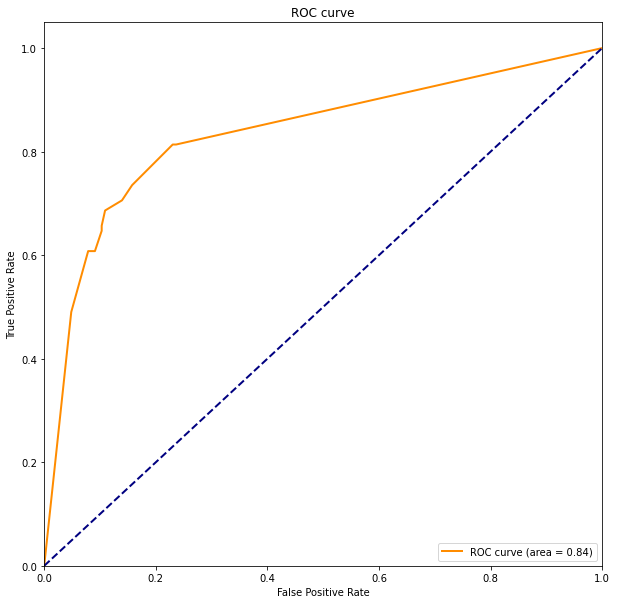

In [71]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model.predict_proba(S_test)[:,1])
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

In [72]:
predictions = model.predict(S_test)
print(classification_report(y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       165
           1       0.80      0.66      0.72       102

    accuracy                           0.81       267
   macro avg       0.80      0.78      0.79       267
weighted avg       0.80      0.81      0.80       267



In [82]:
new_x_train = x_train 
new_x_test = x_test

new_x_train['Family'] = new_x_train.SibSp + new_x_train.Parch
new_x_test['Family'] = new_x_test.SibSp + new_x_test.Parch

,Pclass,Sex,Age,Embarked,Family
748,1,male,19.0,S,1
45,3,male,35.0,S,0
28,3,female,23.0,Q,0
633,1,male,27.0,S,0
403,3,male,28.0,S,1
...,...,...,...,...,...
476,2,male,34.0,S,1
192,3,female,19.0,S,1
736,3,female,48.0,S,4
462,1,male,47.0,S,0


In [83]:
new_x_train.drop(columns=['SibSp', 'Parch'], inplace=True)
new_x_test.drop(columns=['SibSp', 'Parch'], inplace=True)

KeyError: "['SibSp' 'Parch'] not found in axis"

In [84]:
# 연속형 데이터
new_numeric_features = ['Family', 'Age']
# 연속형 데이터 encoder
numeric_transformer = StandardScaler()
# 범주형 데이터
categorical_features = ['Sex', 'Pclass', 'Embarked']
# 범주형 데이터 encoder
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') 

new_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, new_numeric_features),
        ('cat', categorical_transformer, categorical_features)],
)

In [85]:
new_preprocessor_pipe = Pipeline(steps=[('preprocessor', new_preprocessor)])

In [86]:
# x_train데이터 학습시키는 과정
new_preprocessor_pipe.fit(new_x_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Family', 'Age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])]))])

In [87]:
# x_train의 학습을 토대로 One-HotEncoding(), StandardScaler() 적용
new_x_train_transformed = new_preprocessor_pipe.transform(new_x_train)
new_x_test_transformed = new_preprocessor_pipe.transform(new_x_test)

In [90]:
x_train_encoding_new = pd.DataFrame(new_x_train_transformed , columns=['Family', 'Age', 'Female', 'Male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])
x_test_encoding_new =  pd.DataFrame(new_x_test_transformed , columns=['Family', 'Age', 'Female', 'Male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])

In [91]:
model = XGBClassifier(**y_pred.best_params_) 
model = model.fit(S_train, y_train)

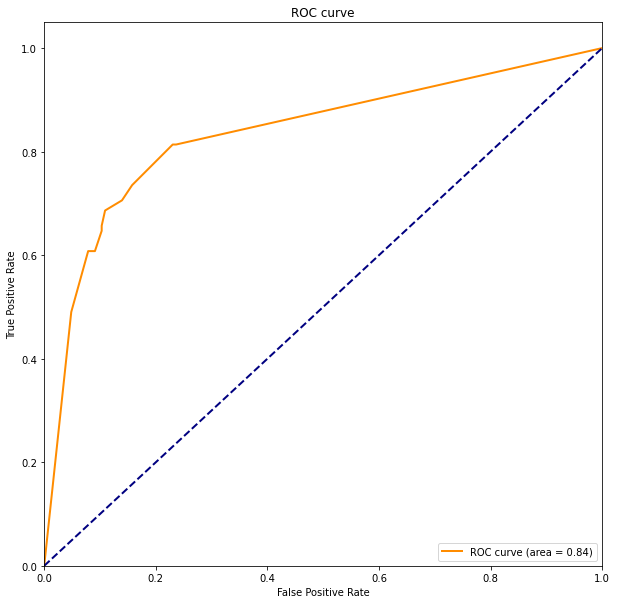

In [92]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model.predict_proba(S_test)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

In [93]:
predictions = model.predict(S_test)
print(classification_report(y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       165
           1       0.80      0.66      0.72       102

    accuracy                           0.81       267
   macro avg       0.80      0.78      0.79       267
weighted avg       0.80      0.81      0.80       267



In [119]:
data_df.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [18]:
data_df.Cabin.isna().sum()

687

In [135]:
data_df.Age.quantile(.75)

38.0

In [142]:
import random

In [143]:
data_df.Age.fillna(random.randrange(20, 41))

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    29.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

ex. 보험사에서 다루는 고객데이터셋 중 나이열에 있는 결측치를 다루려 할 때

- 랜덤 값으로 채우기
- 대표 값으로 채우기(mean평균, median중위값, mode최빈값)
- 위아래 데이터의 평균값으로 채우기
- 행들을 그룹으로 묶은 후 해당 그룹의 대표값으로 채우기
- 머신러닝 예측모델을 만들어 해당 열의 결측치를 채우기
- 특정 기준 이상의 결측치가 있을 시 해당 열 삭제

In [ ]:
x_data.info()

In [ ]:
# # 기본적인 결측치 채우는 방법
# mean_age = x_data['Age'].median(skipna=True)
# x_data['Age'] = x_data['Age'].fillna(mean_age) # or .fillna(int/float/str 값)

<br>

## 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

<br>

## 3. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

<br>

## 4. Train the model

<br>

## 5. Predict on test data & Check the result with metrics (모델 간 비교가 가능합니다.)